In [ ]:
# ============================================================
# STEP 0: SETUP (Imports + Seed)
# ============================================================
import os, glob, shutil, hashlib, random, json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve,
    average_precision_score
)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TF:", tf.__version__)
print("GPU:", tf.config.list_physical_devices("GPU"))

TF: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# ============================================================
# STEP 1: MOUNT GOOGLE DRIVE
# ============================================================
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
# ============================================================
# STEP 2: PATHS (Keep your same LC25000.zip location)
# ============================================================
ZIP_PATH   = "/content/drive/MyDrive/Data/LC25000.zip"  # <-- same as before
EXTRACT_TO = "/content/LC25000"
LUNG_ROOT  = f"{EXTRACT_TO}/lung_image_sets"

# Clean split created in runtime
CLEAN_SPLIT_ROOT = "/content/lung_data_clean_effb0"

# EVERYTHING SAVED HERE (Drive)
SAVE_ROOT = "/content/drive/MyDrive/LungCancer_Project/EfficientNetB0_CLEAN"
MODEL_DIR = os.path.join(SAVE_ROOT, "models")
FIG_DIR   = os.path.join(SAVE_ROOT, "outputs_figures")
RES_DIR   = os.path.join(SAVE_ROOT, "results")

for d in [SAVE_ROOT, MODEL_DIR, FIG_DIR, RES_DIR]:
    os.makedirs(d, exist_ok=True)

CLASSES = ["lung_aca", "lung_n", "lung_scc"]
IMG_EXTS = (".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp")

print("ZIP exists?", os.path.exists(ZIP_PATH))
print("SAVE_ROOT:", SAVE_ROOT)


ZIP exists? True
SAVE_ROOT: /content/drive/MyDrive/LungCancer_Project/EfficientNetB0_CLEAN


In [ ]:
# ============================================================
# STEP 3: UNZIP (only if needed)
# ============================================================
import zipfile

if not os.path.exists(LUNG_ROOT):
    print("Unzipping dataset...")
    os.makedirs(EXTRACT_TO, exist_ok=True)
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(EXTRACT_TO)

print("LUNG_ROOT exists:", os.path.exists(LUNG_ROOT))
print("Classes:", os.listdir(LUNG_ROOT))


Unzipping dataset...
LUNG_ROOT exists: True
Classes: ['lung_aca', 'lung_n', 'lung_scc']


In [ ]:
# ============================================================
# STEP 4: HELPERS (MD5 + folder reset)
# ============================================================
def md5_file(path, chunk_size=1024*1024):
    h = hashlib.md5()
    with open(path, "rb") as f:
        while True:
            b = f.read(chunk_size)
            if not b:
                break
            h.update(b)
    return h.hexdigest()

def reset_dir(d):
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d, exist_ok=True)

def list_class_files(root, cls):
    cls_dir = os.path.join(root, cls)
    files = sorted([p for p in glob.glob(os.path.join(cls_dir, "*")) if p.lower().endswith(IMG_EXTS)])
    return files


In [ ]:
# ============================================================
# STEP 5: GLOBAL DUPLICATE REMOVAL (MD5) + UNIQUE LIST PER CLASS
# ============================================================
hash_to_src = {}   # global uniqueness
unique_by_class = {c: [] for c in CLASSES}
dup_removed = 0

for c in CLASSES:
    files = list_class_files(LUNG_ROOT, c)
    for fp in files:
        h = md5_file(fp)
        if h in hash_to_src:
            dup_removed += 1
            continue
        hash_to_src[h] = fp
        unique_by_class[c].append(fp)

unique_total = sum(len(v) for v in unique_by_class.values())
print("✅ Unique images kept:", unique_total)
print("⚠️ Duplicates removed:", dup_removed)

# Save proof (hash index) to Drive
with open(os.path.join(RES_DIR, "unique_hash_index.json"), "w") as f:
    json.dump(hash_to_src, f)
print("✅ Saved: unique_hash_index.json")


✅ Unique images kept: 14195
⚠️ Duplicates removed: 805
✅ Saved: unique_hash_index.json


In [ ]:
# ============================================================
# STEP 6: CREATE CLEAN SPLITS (70/15/15) — STRATIFIED
#       Output: /content/lung_data_clean_effb0/{train,valid,test}/{class}/...
# ============================================================
reset_dir(CLEAN_SPLIT_ROOT)

split_manifest = {"train": [], "valid": [], "test": []}

for c in CLASSES:
    paths = unique_by_class[c]

    train_paths, temp_paths = train_test_split(
        paths, test_size=0.30, random_state=SEED, shuffle=True
    )
    valid_paths, test_paths = train_test_split(
        temp_paths, test_size=0.50, random_state=SEED, shuffle=True
    )

    for split_name, plist in [("train", train_paths), ("valid", valid_paths), ("test", test_paths)]:
        out_dir = os.path.join(CLEAN_SPLIT_ROOT, split_name, c)
        os.makedirs(out_dir, exist_ok=True)
        for i, src in enumerate(plist):
            ext = os.path.splitext(src)[1].lower()
            new_name = f"{c}_{split_name}_{i:05d}{ext}"
            shutil.copy2(src, os.path.join(out_dir, new_name))
            split_manifest[split_name].append(src)

print("✅ Clean split created:", CLEAN_SPLIT_ROOT)
print("Split folders:", os.listdir(CLEAN_SPLIT_ROOT))

# Save manifest to Drive
with open(os.path.join(RES_DIR, "clean_split_manifest.json"), "w") as f:
    json.dump(split_manifest, f, indent=2)
print("✅ Saved: clean_split_manifest.json")


✅ Clean split created: /content/lung_data_clean_effb0
Split folders: ['train', 'valid', 'test']
✅ Saved: clean_split_manifest.json


In [ ]:
# ============================================================
# STEP 7: VERIFY ZERO OVERLAP BETWEEN SPLITS (MD5)
# ============================================================
def collect_hashes(split_name):
    hset = set()
    for c in CLASSES:
        files = glob.glob(os.path.join(CLEAN_SPLIT_ROOT, split_name, c, "*"))
        for fp in files:
            if fp.lower().endswith(IMG_EXTS):
                hset.add(md5_file(fp))
    return hset

train_h = collect_hashes("train")
valid_h = collect_hashes("valid")
test_h  = collect_hashes("test")

print("train hashes:", len(train_h))
print("valid hashes:", len(valid_h))
print("test  hashes:", len(test_h))

print("train∩valid:", len(train_h & valid_h))
print("train∩test :", len(train_h & test_h))
print("valid∩test :", len(valid_h & test_h))

assert len(train_h & valid_h) == 0
assert len(train_h & test_h) == 0
assert len(valid_h & test_h) == 0
print("✅ NO OVERLAP CONFIRMED.")


train hashes: 9934
valid hashes: 2130
test  hashes: 2131
train∩valid: 0
train∩test : 0
valid∩test : 0
✅ NO OVERLAP CONFIRMED.


In [ ]:
# ============================================================
# STEP 8: DATA GENERATORS (EfficientNet preprocess)
# ============================================================
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

IMG_SIZE = 160
BATCH = 32

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True
)

eval_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    os.path.join(CLEAN_SPLIT_ROOT, "train"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

valid_ds = eval_gen.flow_from_directory(
    os.path.join(CLEAN_SPLIT_ROOT, "valid"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode="categorical",
    shuffle=False
)

test_ds = eval_gen.flow_from_directory(
    os.path.join(CLEAN_SPLIT_ROOT, "test"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode="categorical",
    shuffle=False
)

labels = list(train_ds.class_indices.keys())
print("Class indices:", train_ds.class_indices)

with open(os.path.join(RES_DIR, "class_indices.json"), "w") as f:
    json.dump(train_ds.class_indices, f, indent=2)


Found 9934 images belonging to 3 classes.
Found 2130 images belonging to 3 classes.
Found 2131 images belonging to 3 classes.
Class indices: {'lung_aca': 0, 'lung_n': 1, 'lung_scc': 2}


In [ ]:
# ============================================================
# STEP 9: BUILD EfficientNet-B0 MODEL
# ============================================================
from tensorflow.keras import layers, models

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base.trainable = False  # Stage-1 freeze

model = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(len(labels), activation="softmax")
])

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# ============================================================
# STEP 10: CALLBACKS (save best to /content, then copy to Drive)
# ============================================================
BEST_LOCAL = "/content/best_effnetb0_clean.keras"
BEST_DRIVE = os.path.join(MODEL_DIR, "best_effnetb0_clean.keras")
FINAL_DRIVE = os.path.join(MODEL_DIR, "final_effnetb0_clean.keras")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        BEST_LOCAL, monitor="val_accuracy", save_best_only=True, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, verbose=1
    )
]

print("✅ Best local:", BEST_LOCAL)
print("✅ Best drive:", BEST_DRIVE)


✅ Best local: /content/best_effnetb0_clean.keras
✅ Best drive: /content/drive/MyDrive/LungCancer_Project/EfficientNetB0_CLEAN/models/best_effnetb0_clean.keras


In [ ]:
# ============================================================
# STEP 11: STAGE 1 TRAINING (Head only)
# ============================================================
EPOCHS_STAGE1 = 6

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history1 = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS_STAGE1,
    callbacks=callbacks,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.6360 - loss: 0.8064
Epoch 1: val_accuracy improved from -inf to 0.86854, saving model to /content/best_effnetb0_clean.keras
311/311 ━━━━━━━━━━━━━━━━━━━━ 156s 413ms/step - accuracy: 0.6364 - loss: 0.8059 - val_accuracy: 0.8685 - val_loss: 0.3893 - learning_rate: 1.0000e-04
Epoch 2/6
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8540 - loss: 0.4179
Epoch 2: val_accuracy improved from 0.86854 to 0.89718, saving model to /content/best_effnetb0_clean.keras
311/311 ━━━━━━━━━━━━━━━━━━━━ 95s 304ms/step - accuracy: 0.8541 - loss: 0.4178 - val_accuracy: 0.8972 - val_loss: 0.2864 - learning_rate: 1.0000e-04
Epoch 3/6
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8873 - loss: 0.3184
Epoch 3: val_accuracy improved from 0.89718 to 0.91127, saving model to /content/best_effnetb0_clean.keras
311/311 ━━━━━━━━━━━━━━━━━━━━ 96s 309ms/step - accuracy: 0.8873 - loss: 0.3184 - val_accuracy: 0.9113 - val_loss: 0.2429 - le

In [ ]:
# ============================================================
# STEP 12: STAGE 2 FINE-TUNING (Unfreeze top layers)
# ============================================================
EPOCHS_STAGE2 = 12
UNFREEZE_LAST_N = 40

base.trainable = True
for layer in base.layers[:-UNFREEZE_LAST_N]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history2 = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS_STAGE2,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/12
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.8984 - loss: 0.2929
Epoch 1: val_accuracy improved from 0.93850 to 0.96526, saving model to /content/best_effnetb0_clean.keras
311/311 ━━━━━━━━━━━━━━━━━━━━ 157s 401ms/step - accuracy: 0.8984 - loss: 0.2927 - val_accuracy: 0.9653 - val_loss: 0.1031 - learning_rate: 5.0000e-05
Epoch 2/12
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9528 - loss: 0.1325
Epoch 2: val_accuracy improved from 0.96526 to 0.98263, saving model to /content/best_effnetb0_clean.keras
311/311 ━━━━━━━━━━━━━━━━━━━━ 100s 323ms/step - accuracy: 0.9528 - loss: 0.1324 - val_accuracy: 0.9826 - val_loss: 0.0644 - learning_rate: 5.0000e-05
Epoch 3/12
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9609 - loss: 0.0995
Epoch 3: val_accuracy improved from 0.98263 to 0.98873, saving model to /content/best_effnetb0_clean.keras
311/311 ━━━━━━━━━━━━━━━━━━━━ 96s 309ms/step - accuracy: 0.9609 - loss: 0.0995 - val_accuracy: 0.9887 - val_loss: 0.04

In [ ]:
# ============================================================
# STEP 13: SAVE MODELS SAFELY TO DRIVE (BEST + FINAL)
# ============================================================
import shutil

# Copy best checkpoint to Drive
assert os.path.exists(BEST_LOCAL), "❌ BEST_LOCAL not found. Training may not have saved."
shutil.copy2(BEST_LOCAL, BEST_DRIVE)
print("✅ Best model saved to Drive:", BEST_DRIVE)

# Save final model to Drive
model.save(FINAL_DRIVE)
print("✅ Final model saved to Drive:", FINAL_DRIVE)


✅ Best model saved to Drive: /content/drive/MyDrive/LungCancer_Project/EfficientNetB0_CLEAN/models/best_effnetb0_clean.keras
✅ Final model saved to Drive: /content/drive/MyDrive/LungCancer_Project/EfficientNetB0_CLEAN/models/final_effnetb0_clean.keras


✅ Histories saved.


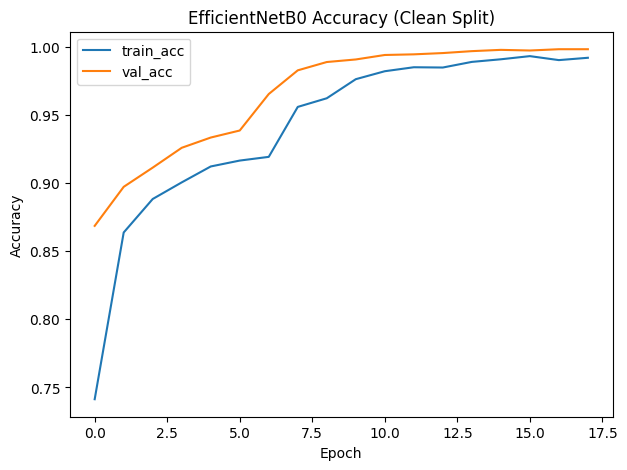

✅ Saved: /content/drive/MyDrive/LungCancer_Project/EfficientNetB0_CLEAN/outputs_figures/effnetb0_accuracy.png


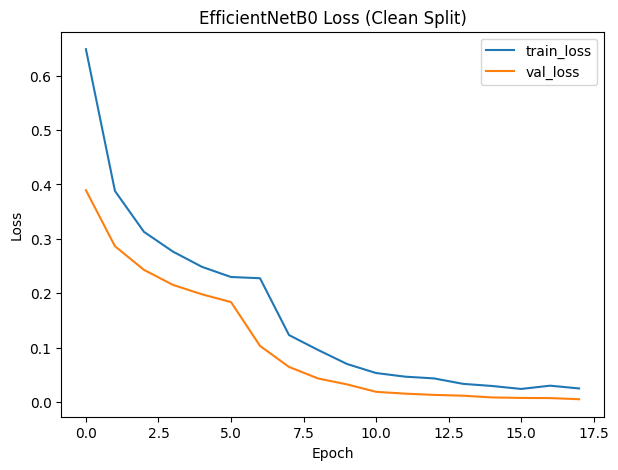

✅ Saved: /content/drive/MyDrive/LungCancer_Project/EfficientNetB0_CLEAN/outputs_figures/effnetb0_loss.png


In [ ]:
# ============================================================
# STEP 14: SAVE TRAINING HISTORY (JSON) + PLOT CURVES
# ============================================================
def save_history(h, path):
    with open(path, "w") as f:
        json.dump(h.history, f)

save_history(history1, os.path.join(RES_DIR, "history_stage1.json"))
save_history(history2, os.path.join(RES_DIR, "history_stage2.json"))
print("✅ Histories saved.")

def merge_hist(h1, h2):
    out = {}
    for k in h1.history.keys():
        out[k] = list(h1.history[k]) + list(h2.history.get(k, []))
    return out

H = merge_hist(history1, history2)

# Accuracy
plt.figure(figsize=(7,5))
plt.plot(H["accuracy"], label="train_acc")
plt.plot(H["val_accuracy"], label="val_acc")
plt.title("EfficientNetB0 Accuracy (Clean Split)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
acc_path = os.path.join(FIG_DIR, "effnetb0_accuracy.png")
plt.savefig(acc_path, dpi=300, bbox_inches="tight")
plt.show()
print("✅ Saved:", acc_path)

# Loss
plt.figure(figsize=(7,5))
plt.plot(H["loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.title("EfficientNetB0 Loss (Clean Split)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
loss_path = os.path.join(FIG_DIR, "effnetb0_loss.png")
plt.savefig(loss_path, dpi=300, bbox_inches="tight")
plt.show()
print("✅ Saved:", loss_path)


✅ CLEAN TEST Accuracy: 0.9967 | Loss: 0.0088
✅ Saved: /content/drive/MyDrive/LungCancer_Project/EfficientNetB0_CLEAN/results/effnetb0_test_results.txt


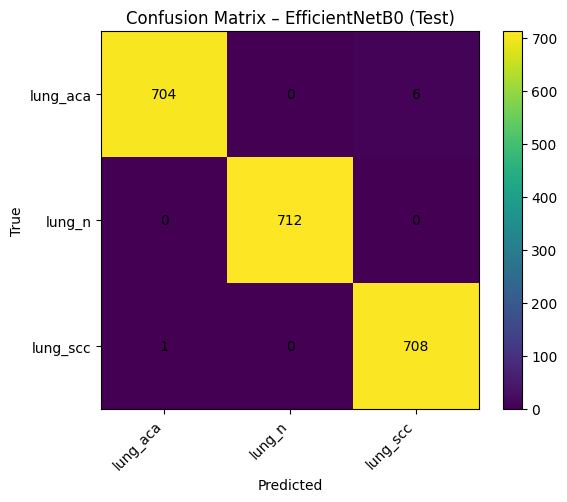

✅ Saved: /content/drive/MyDrive/LungCancer_Project/EfficientNetB0_CLEAN/outputs_figures/effnetb0_confusion_matrix.png


In [ ]:
# ============================================================
# STEP 15: TEST EVALUATION + REPORT + CONFUSION MATRIX + SAVE
# ============================================================
best_model = tf.keras.models.load_model(BEST_LOCAL)

test_loss, test_acc = best_model.evaluate(test_ds, verbose=0)
print(f"✅ CLEAN TEST Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")

probs = best_model.predict(test_ds, verbose=0)
y_pred = np.argmax(probs, axis=1)
y_true = test_ds.classes

report = classification_report(y_true, y_pred, target_names=labels, digits=4)
cm = confusion_matrix(y_true, y_pred)

np.save(os.path.join(RES_DIR, "y_true.npy"), y_true)
np.save(os.path.join(RES_DIR, "y_pred.npy"), y_pred)

# Save text report
res_txt = os.path.join(RES_DIR, "effnetb0_test_results.txt")
with open(res_txt, "w") as f:
    f.write(f"CLEAN TEST Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(report + "\n\n")
    f.write("Confusion Matrix:\n")
    f.write(str(cm) + "\n")

print("✅ Saved:", res_txt)

# Confusion Matrix plot
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix – EfficientNetB0 (Test)")
plt.colorbar()
ticks = np.arange(len(labels))
plt.xticks(ticks, labels, rotation=45, ha="right")
plt.yticks(ticks, labels)
plt.xlabel("Predicted"); plt.ylabel("True")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

cm_path = os.path.join(FIG_DIR, "effnetb0_confusion_matrix.png")
plt.tight_layout()
plt.savefig(cm_path, dpi=300, bbox_inches="tight")
plt.show()
print("✅ Saved:", cm_path)


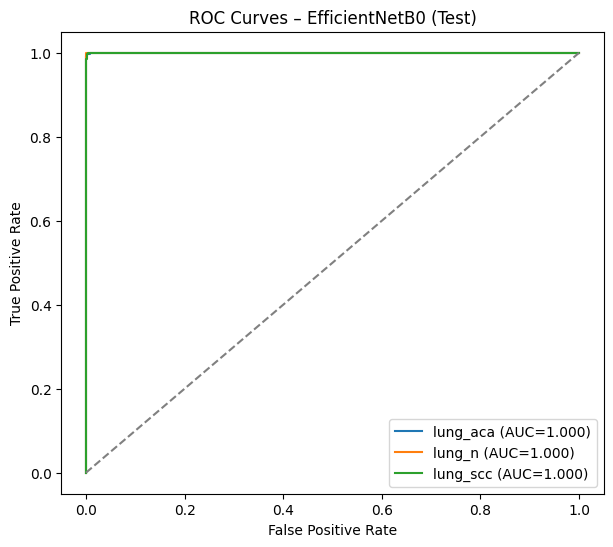

✅ Saved: /content/drive/MyDrive/LungCancer_Project/EfficientNetB0_CLEAN/outputs_figures/effnetb0_roc.png


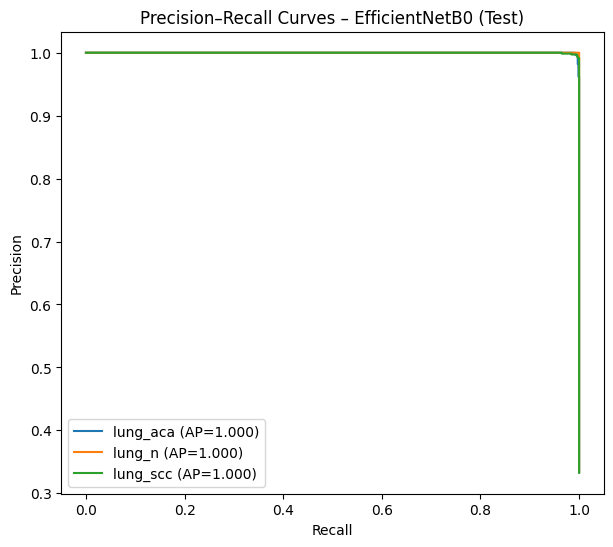

✅ Saved: /content/drive/MyDrive/LungCancer_Project/EfficientNetB0_CLEAN/outputs_figures/effnetb0_pr.png


In [ ]:
# ============================================================
# STEP 16: ROC + PR CURVES (OvR) + SAVE
# ============================================================
y_true_oh = tf.keras.utils.to_categorical(y_true, num_classes=len(labels))

# ROC
plt.figure(figsize=(7,6))
for i, name in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_true_oh[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves – EfficientNetB0 (Test)")
plt.legend()
roc_path = os.path.join(FIG_DIR, "effnetb0_roc.png")
plt.savefig(roc_path, dpi=300, bbox_inches="tight")
plt.show()
print("✅ Saved:", roc_path)

# PR
plt.figure(figsize=(7,6))
for i, name in enumerate(labels):
    prec, rec, _ = precision_recall_curve(y_true_oh[:, i], probs[:, i])
    ap = average_precision_score(y_true_oh[:, i], probs[:, i])
    plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curves – EfficientNetB0 (Test)")
plt.legend()
pr_path = os.path.join(FIG_DIR, "effnetb0_pr.png")
plt.savefig(pr_path, dpi=300, bbox_inches="tight")
plt.show()
print("✅ Saved:", pr_path)


In [ ]:
# ============================================================
# FIX: Build/Connect the model graph (required for Grad-CAM)
# ============================================================
import numpy as np
import tensorflow as tf
import os, cv2
import matplotlib.pyplot as plt

IMG_SIZE = 160
BACKBONE_NAME = "efficientnetb0"
TARGET_LAYER_NAME = "top_conv"   # inside backbone

# 1) FORCE-BUILD the model graph
dummy = np.zeros((1, IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
_ = best_model(dummy, training=False)   # <-- this line fixes "never been called"
print("✅ best_model graph is now built/connected.")


✅ best_model graph is now built/connected.


In [ ]:
import tensorflow as tf
import numpy as np

BEST_LOCAL = "/content/best_effnetb0_clean.keras"   # your checkpoint
IMG_SIZE = 160

# Reload cleanly
best_model = tf.keras.models.load_model(BEST_LOCAL, compile=False)

# Force graph build (this must run BEFORE building grad_model)
dummy = np.zeros((1, IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
_ = best_model.predict(dummy, verbose=0)

print("✅ Model reloaded and graph connected.")
print("Top layers:", [l.name for l in best_model.layers])


✅ Model reloaded and graph connected.
Top layers: ['efficientnetb0', 'global_average_pooling2d', 'dropout', 'dense']


In [ ]:
import tensorflow as tf

BACKBONE_NAME = "efficientnetb0"
TARGET_LAYER_NAME = "top_conv"   # EfficientNetB0 last conv layer

backbone = best_model.get_layer(BACKBONE_NAME)
print("✅ Backbone layers sample:", [l.name for l in backbone.layers][-5:])

target_layer = backbone.get_layer(TARGET_LAYER_NAME)

grad_model = tf.keras.models.Model(
    inputs=best_model.inputs,
    outputs=[target_layer.output, best_model.outputs[0]]
)

print("✅ grad_model built with target layer:", TARGET_LAYER_NAME)


✅ Backbone layers sample: ['block7a_project_conv', 'block7a_project_bn', 'top_conv', 'top_bn', 'top_activation']
✅ grad_model built with target layer: top_conv


In [ ]:
import tensorflow as tf
import numpy as np

IMG_SIZE = 160
BACKBONE_NAME = "efficientnetb0"
TARGET_LAYER_NAME = "top_conv"   # inside backbone

backbone = best_model.get_layer(BACKBONE_NAME)

# Force-build backbone graph
dummy = np.zeros((1, IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
_ = backbone(dummy, training=False)

target_layer = backbone.get_layer(TARGET_LAYER_NAME)

# Grad model ONLY for backbone: input -> (conv activations)
backbone_grad_model = tf.keras.models.Model(
    inputs=backbone.input,
    outputs=target_layer.output
)

print("✅ backbone_grad_model built.")
print("Backbone input:", backbone.input)
print("Target layer:", TARGET_LAYER_NAME)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 160, 160, 3))
  warnings.warn(msg)


✅ backbone_grad_model built.
Backbone input: [<KerasTensor shape=(None, 160, 160, 3), dtype=float32, sparse=False, ragged=False, name=input_layer>]
Target layer: top_conv


In [ ]:
import tensorflow as tf
import numpy as np

def compute_gradcam(best_model, backbone, backbone_grad_model, img_batch_1, class_idx=None):
    """
    img_batch_1: (1,H,W,3) numpy array from DirectoryIterator
    """
    # ✅ Convert numpy -> tf.Tensor
    img_tensor = tf.convert_to_tensor(img_batch_1, dtype=tf.float32)

    # Predicted class from full model
    preds_np = best_model.predict(img_batch_1, verbose=0)
    if class_idx is None:
        class_idx = int(np.argmax(preds_np[0]))

    with tf.GradientTape() as tape:
        # conv activations from backbone
        conv_out = backbone_grad_model(img_tensor, training=False)   # (1,h,w,c)
        # class score from full model
        full_preds = best_model(img_tensor, training=False)          # (1,num_classes)
        loss = full_preds[:, class_idx]

    grads = tape.gradient(loss, conv_out)  # (1,h,w,c)

    conv_out = conv_out[0]
    grads = grads[0]

    weights = tf.reduce_mean(grads, axis=(0, 1))      # (c,)
    cam = tf.reduce_sum(conv_out * weights, axis=-1)  # (h,w)
    cam = tf.maximum(cam, 0)
    cam = cam / (tf.reduce_max(cam) + 1e-8)

    return cam.numpy(), class_idx


In [ ]:
import tensorflow as tf
import numpy as np

IMG_SIZE = 160
BACKBONE_NAME = "efficientnetb0"
TARGET_LAYER_NAME = "top_conv"

# Extract parts from your trained Sequential model
backbone = best_model.get_layer(BACKBONE_NAME)
gap = best_model.get_layer("global_average_pooling2d")
drop = best_model.get_layer("dropout")
dense = best_model.get_layer("dense")

# Ensure backbone has a graph
dummy = np.zeros((1, IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
_ = backbone(dummy, training=False)

# Target conv layer inside backbone
target_layer = backbone.get_layer(TARGET_LAYER_NAME)

# Build a single connected model: input -> (conv_map, preds)
inp = backbone.input
conv_map = target_layer.output              # (h,w,c)
feat = backbone.output                      # (H,W,C) backbone final feature map
x = gap(feat)
x = drop(x, training=False)                 # dropout off for visualization
preds = dense(x)

grad_model = tf.keras.models.Model(inp, [conv_map, preds])
print("✅ Connected grad_model built (conv_map + preds).")
print("Target layer:", TARGET_LAYER_NAME)


✅ Connected grad_model built (conv_map + preds).
Target layer: top_conv


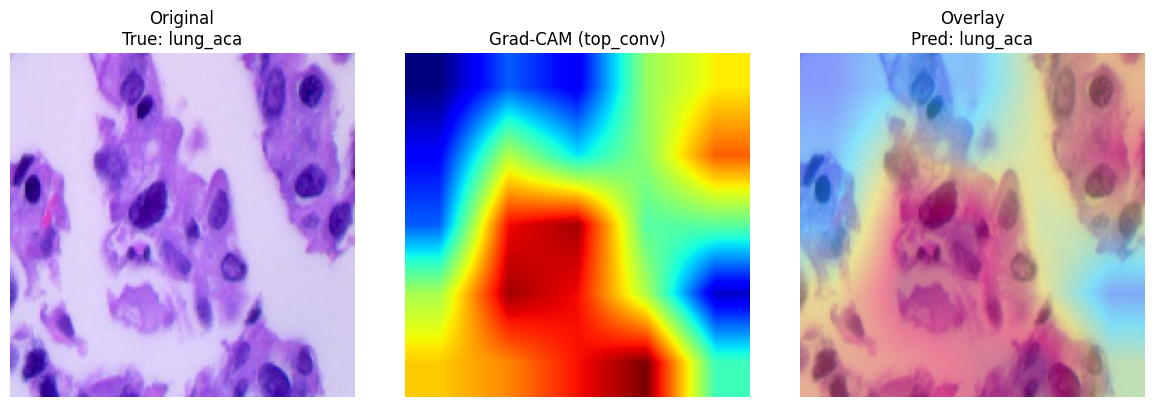

✅ Saved: /content/drive/MyDrive/LungCancer_Project/EfficientNetB0_CLEAN/outputs_figures/EffNetB0_CLEAN_gradcam_0.png


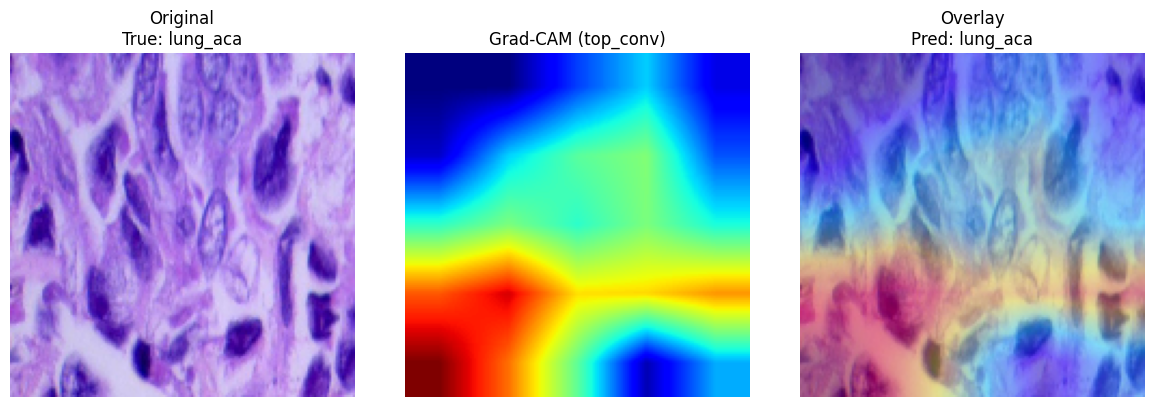

✅ Saved: /content/drive/MyDrive/LungCancer_Project/EfficientNetB0_CLEAN/outputs_figures/EffNetB0_CLEAN_gradcam_1.png


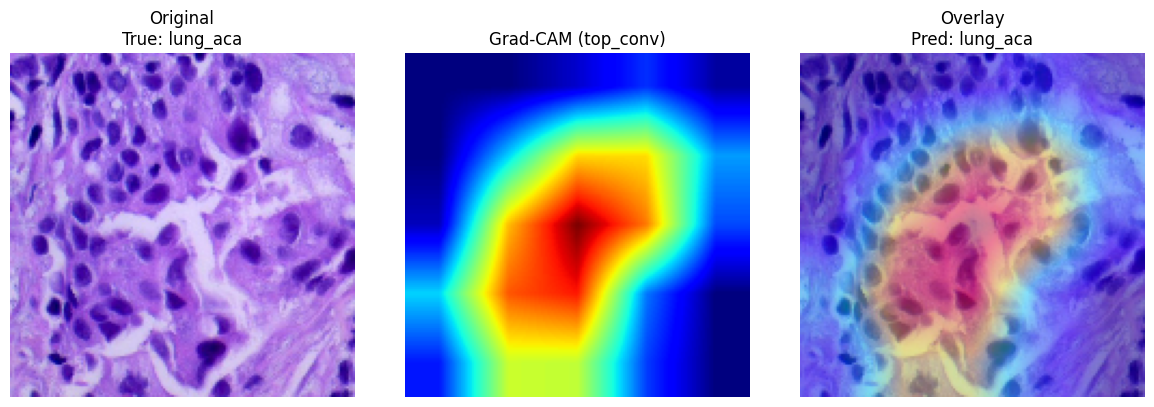

✅ Saved: /content/drive/MyDrive/LungCancer_Project/EfficientNetB0_CLEAN/outputs_figures/EffNetB0_CLEAN_gradcam_2.png


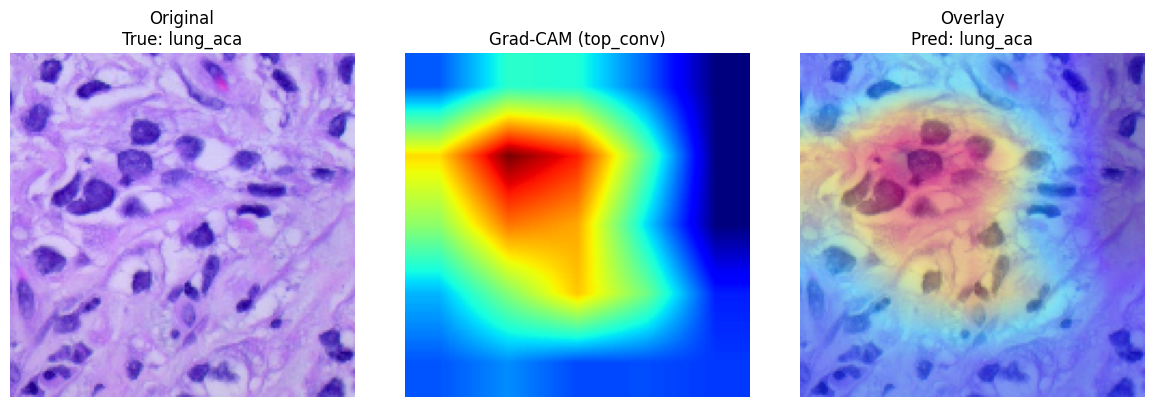

✅ Saved: /content/drive/MyDrive/LungCancer_Project/EfficientNetB0_CLEAN/outputs_figures/EffNetB0_CLEAN_gradcam_3.png


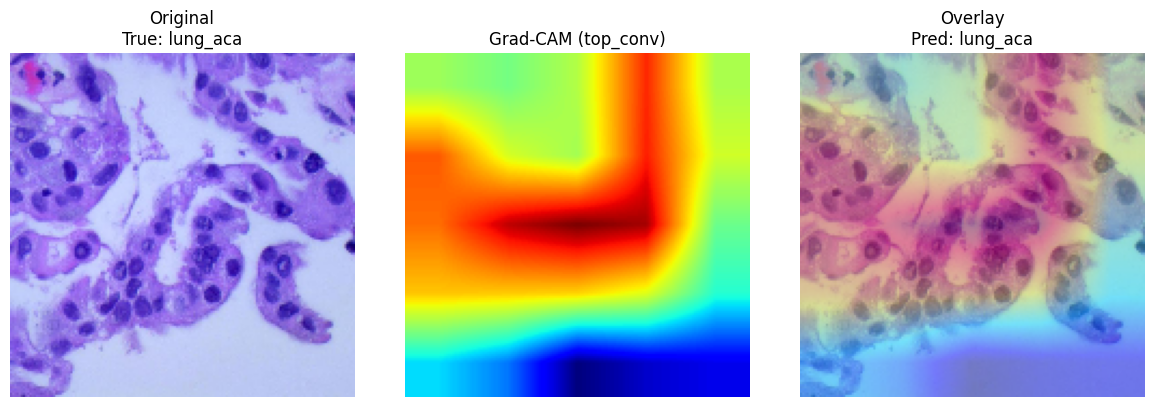

✅ Saved: /content/drive/MyDrive/LungCancer_Project/EfficientNetB0_CLEAN/outputs_figures/EffNetB0_CLEAN_gradcam_4.png


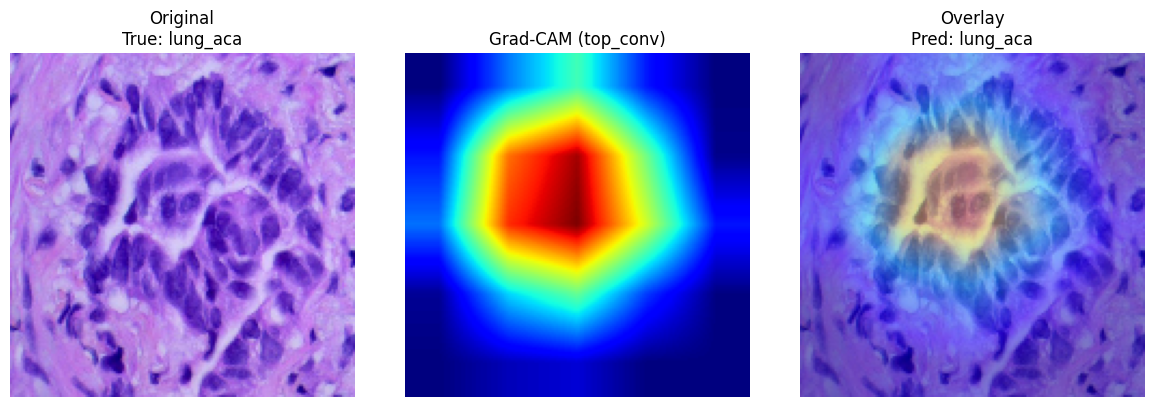

✅ Saved: /content/drive/MyDrive/LungCancer_Project/EfficientNetB0_CLEAN/outputs_figures/EffNetB0_CLEAN_gradcam_5.png


In [ ]:
import cv2, os
import matplotlib.pyplot as plt

def deprocess_for_display(x):
    x = x.copy()
    x = (x - x.min()) / (x.max() - x.min() + 1e-8)
    return x

def make_gradcam(img_np_1):
    img = tf.convert_to_tensor(img_np_1, dtype=tf.float32)

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img, training=False)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]

    grads = tape.gradient(loss, conv_out)          # (1,h,w,c)
    conv_out = conv_out[0]
    grads = grads[0]

    weights = tf.reduce_mean(grads, axis=(0, 1))   # (c,)
    cam = tf.reduce_sum(conv_out * weights, axis=-1)
    cam = tf.maximum(cam, 0)
    cam = cam / (tf.reduce_max(cam) + 1e-8)
    return cam.numpy(), int(class_idx.numpy())

def show_gradcam_samples(test_ds, n=6, prefix="EffNetB0_CLEAN"):
    if hasattr(test_ds, "reset"):
        test_ds.reset()

    xb, yb = test_ds[0]
    n = min(n, xb.shape[0])
    saved = []

    for i in range(n):
        img = xb[i:i+1]
        true_idx = int(np.argmax(yb[i]))

        cam, pred_idx = make_gradcam(img)
        cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))

        disp = deprocess_for_display(img[0])
        disp_uint8 = (255 * disp).astype("uint8")

        heat = cv2.applyColorMap((255 * cam).astype("uint8"), cv2.COLORMAP_JET)
        heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)
        overlay = cv2.addWeighted(disp_uint8, 0.6, heat, 0.4, 0)

        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].imshow(disp_uint8); ax[0].axis("off")
        ax[0].set_title(f"Original\nTrue: {labels[true_idx]}")
        ax[1].imshow(cam, cmap="jet"); ax[1].axis("off")
        ax[1].set_title(f"Grad-CAM ({TARGET_LAYER_NAME})")
        ax[2].imshow(overlay); ax[2].axis("off")
        ax[2].set_title(f"Overlay\nPred: {labels[pred_idx]}")
        plt.tight_layout()

        out_path = os.path.join(FIG_DIR, f"{prefix}_gradcam_{i}.png")
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        plt.show()
        plt.close(fig)

        print("✅ Saved:", out_path)
        saved.append(out_path)

    return saved

gradcam_paths = show_gradcam_samples(test_ds, n=6, prefix="EffNetB0_CLEAN")


In [ ]:
import numpy as np
import cv2

def score_gradcam(cam):
    # higher score = stronger, more localized activation
    return cam.mean() + cam.max()

def collect_best_gradcams(best_model, test_ds, n_batches=5, top_k=6):
    if hasattr(test_ds, "reset"):
        test_ds.reset()

    scored = []

    for b in range(n_batches):
        xb, yb = test_ds[b]
        for i in range(xb.shape[0]):
            img = xb[i:i+1]
            cam, pred_idx = make_gradcam(img)
            score = score_gradcam(cam)

            scored.append({
                "img": img,
                "cam": cam,
                "true": int(np.argmax(yb[i])),
                "pred": pred_idx,
                "score": score
            })

    scored = sorted(scored, key=lambda x: x["score"], reverse=True)
    return scored[:top_k]

best_list = collect_best_gradcams(best_model, test_ds, n_batches=6, top_k=6)
print("✅ Selected top Grad-CAM samples")


✅ Selected top Grad-CAM samples


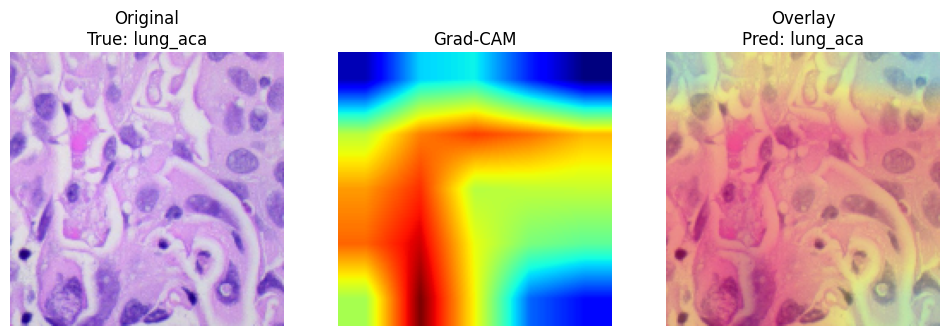

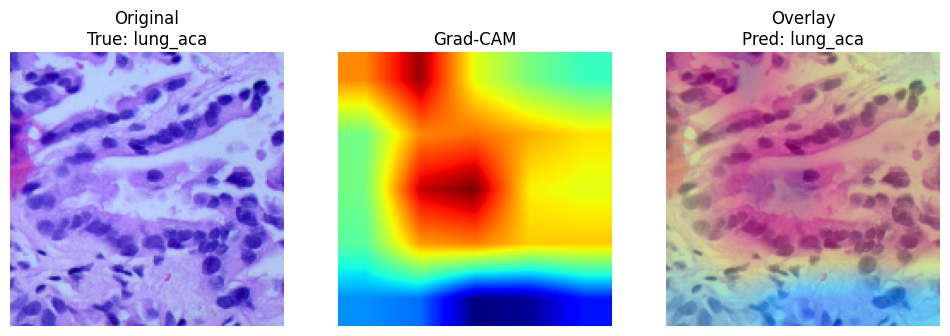

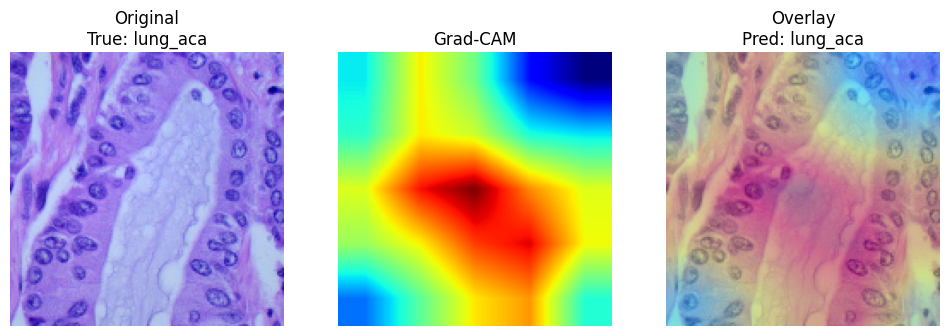

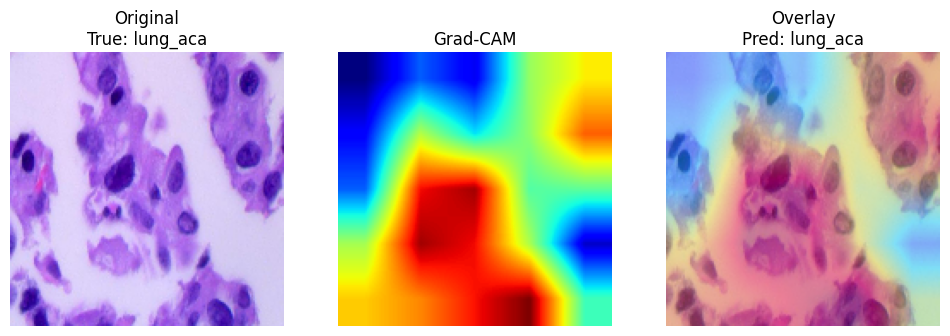

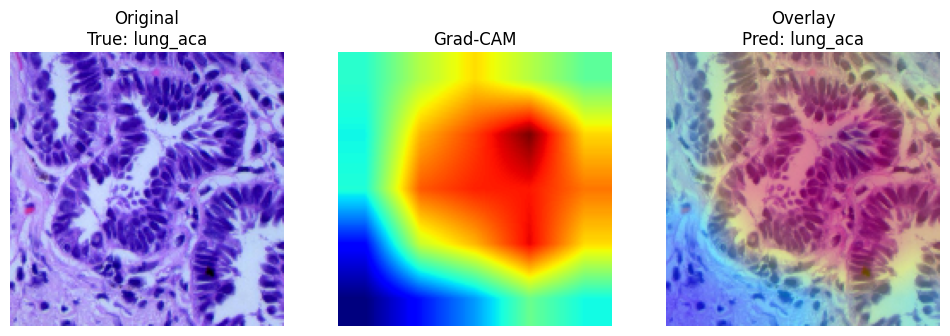

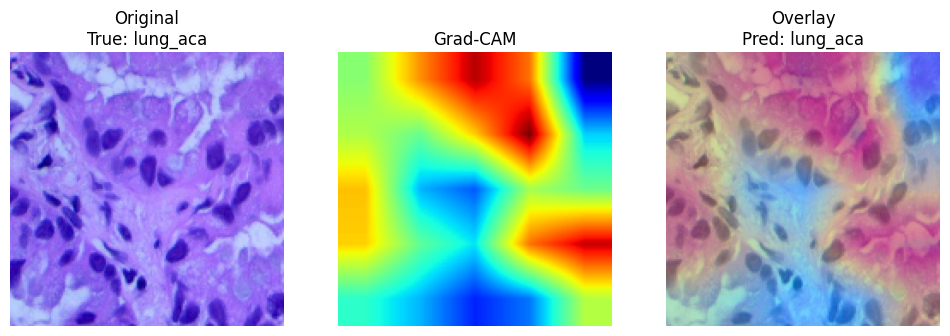

✅ Saved best Grad-CAM figures: ['/content/drive/MyDrive/LungCancer_Project/outputs_figures/EffNetB0_gradcam_best_0.png', '/content/drive/MyDrive/LungCancer_Project/outputs_figures/EffNetB0_gradcam_best_1.png', '/content/drive/MyDrive/LungCancer_Project/outputs_figures/EffNetB0_gradcam_best_2.png', '/content/drive/MyDrive/LungCancer_Project/outputs_figures/EffNetB0_gradcam_best_3.png', '/content/drive/MyDrive/LungCancer_Project/outputs_figures/EffNetB0_gradcam_best_4.png', '/content/drive/MyDrive/LungCancer_Project/outputs_figures/EffNetB0_gradcam_best_5.png']


In [ ]:
import matplotlib.pyplot as plt
import os

FIG_DIR = "/content/drive/MyDrive/LungCancer_Project/outputs_figures"
os.makedirs(FIG_DIR, exist_ok=True)

saved_paths = []

for i, d in enumerate(best_list):
    cam = cv2.resize(d["cam"], (IMG_SIZE, IMG_SIZE))
    img = d["img"][0]

    disp = (img - img.min()) / (img.max() - img.min() + 1e-8)
    disp = (255 * disp).astype("uint8")

    heat = cv2.applyColorMap((255 * cam).astype("uint8"), cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(disp, 0.6, heat, 0.4, 0)

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(disp); ax[0].axis("off")
    ax[0].set_title(f"Original\nTrue: {labels[d['true']]}")
    ax[1].imshow(cam, cmap="jet"); ax[1].axis("off")
    ax[1].set_title("Grad-CAM")
    ax[2].imshow(overlay); ax[2].axis("off")
    ax[2].set_title(f"Overlay\nPred: {labels[d['pred']]}")

    out_path = os.path.join(FIG_DIR, f"EffNetB0_gradcam_best_{i}.png")
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

    saved_paths.append(out_path)

print("✅ Saved best Grad-CAM figures:", saved_paths)


In [ ]:
from PIL import Image

def make_montage(paths, out_path, cols=3):
    imgs = [Image.open(p) for p in paths]
    w, h = imgs[0].size
    rows = (len(imgs) + cols - 1) // cols

    montage = Image.new("RGB", (cols*w, rows*h), (255,255,255))
    for idx, im in enumerate(imgs):
        r, c = divmod(idx, cols)
        montage.paste(im, (c*w, r*h))

    montage.save(out_path)
    print("✅ Montage saved:", out_path)

montage_path = os.path.join(FIG_DIR, "EffNetB0_GradCAM_Montage.png")
make_montage(saved_paths, montage_path, cols=3)


✅ Montage saved: /content/drive/MyDrive/LungCancer_Project/outputs_figures/EffNetB0_GradCAM_Montage.png


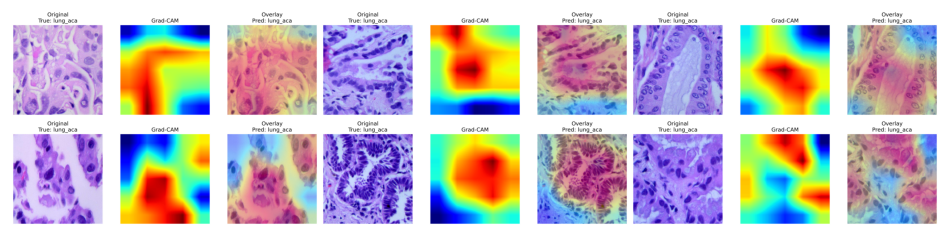

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

montage_path = "/content/drive/MyDrive/LungCancer_Project/outputs_figures/EffNetB0_GradCAM_Montage.png"

img = Image.open(montage_path)
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis("off")
plt.show()


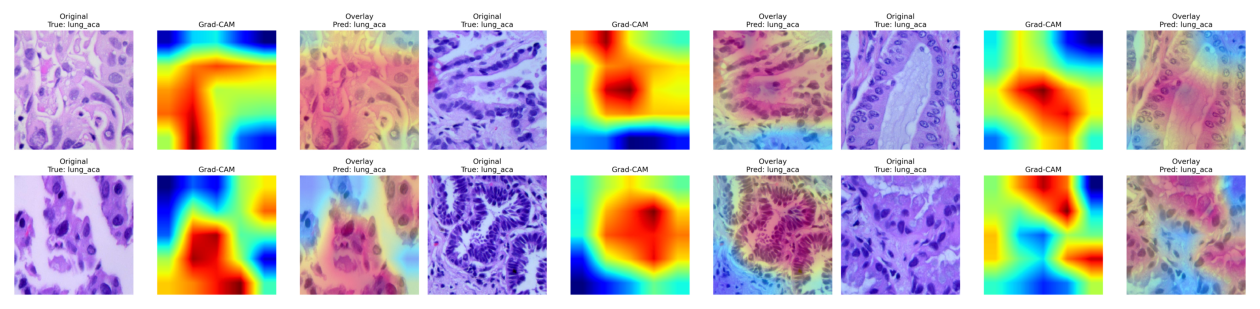

In [ ]:
plt.figure(figsize=(16, 10))
plt.imshow(img)
plt.axis("off")
plt.show()


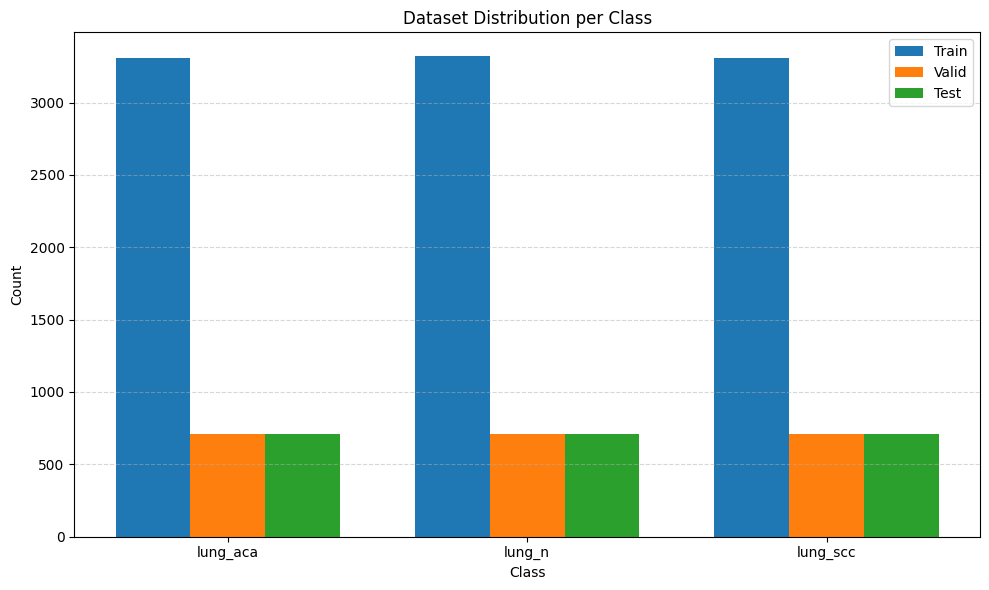

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Class names from generator
class_names = list(train_ds.class_indices.keys())

def count_from_generator(gen):
    counts = np.zeros(len(class_names), dtype=int)
    for cls_idx in gen.classes:
        counts[cls_idx] += 1
    return counts

train_counts = count_from_generator(train_ds)
valid_counts = count_from_generator(valid_ds)
test_counts  = count_from_generator(test_ds)

# Plot
x = np.arange(len(class_names))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, train_counts, width, label="Train")
plt.bar(x, valid_counts, width, label="Valid")
plt.bar(x + width, test_counts, width, label="Test")

plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Dataset Distribution per Class")
plt.xticks(x, class_names)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()
